In [117]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]
# !pip install quandl
#import quandl

import warnings
warnings.filterwarnings("ignore")

In [118]:
rates = pd.read_excel('/content/drive/MyDrive/rates.xlsx', index_col='Month')
rates=rates.sort_index()
rates.head()

,0.25,0.50,0.75,1.00,2.00,3.00,5.00,7.00,10.00,15.00,20.00,30.00
Month,,,,,,,,,,,,
2017-01-03,8.46,8.45,8.43,8.40,8.25,8.21,8.22,8.28,8.42,8.66,8.85,9.09
2017-01-04,8.41,8.43,8.43,8.39,8.18,8.14,8.19,8.29,8.44,8.69,8.88,9.12
2017-01-05,8.50,8.47,8.42,8.37,8.17,8.13,8.16,8.24,8.37,8.63,8.84,9.09
2017-01-06,8.34,8.36,8.36,8.35,8.24,8.17,8.15,8.21,8.35,8.60,8.80,9.06
2017-01-09,8.67,8.62,8.56,8.49,8.23,8.16,8.11,8.12,8.21,8.43,8.63,8.90


In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


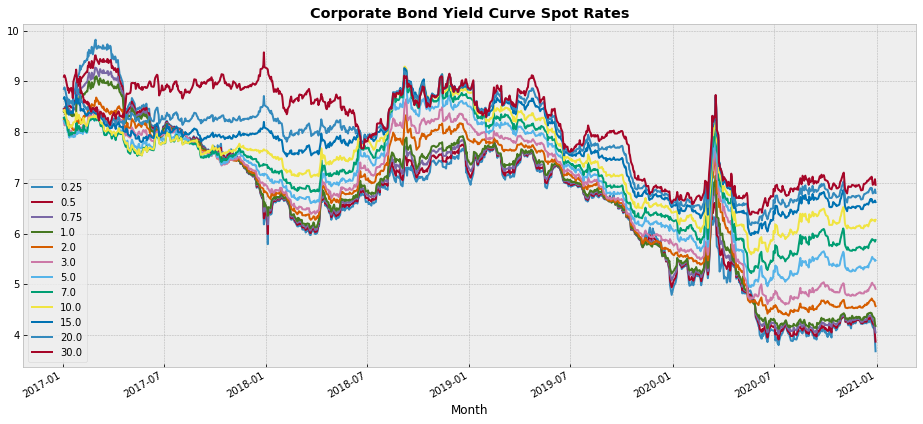

In [120]:
rates.loc[:, [0.25,	0.50,	0.75,	1.00,	2.00,	3.00,	5.00,	7.00,	10.00,	15.00,	20.00,	30.00]].plot(figsize=(16, 7))
plt.title("Corporate Bond Yield Curve Spot Rates", weight="bold")

plt.show()

In [121]:
print(rates.index)

rates.index = rates.index.to_period(freq='d')

print(rates.index)

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Month', length=1004, freq=None)
PeriodIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
             '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
             '2017-01-13', '2017-01-16',
             ...
             '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
             '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-28',
             '2020-12-29', '2020-12-30'],
            dtype='period[D]', name='Month', length=1004, freq='D')


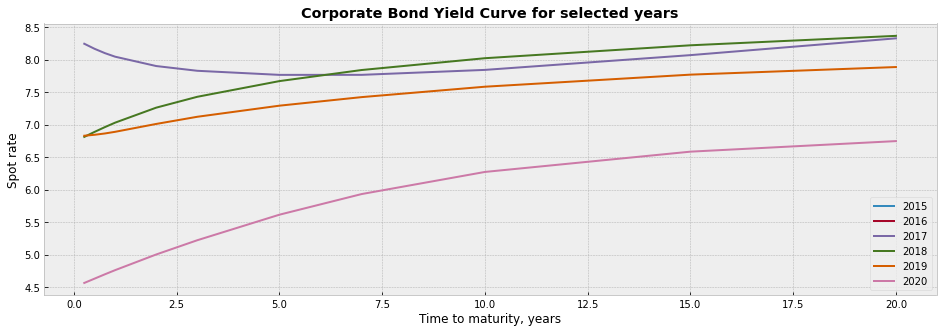

In [122]:
years = [x for x in range(2015, 2021)]

fig = plt.figure(figsize=(16, 5))
for y in years:
    
    plt.plot(rates.loc[rates.index.year == y, rates.columns.astype(float) < 21].mean(axis=0), lw=2)

plt.xlabel('Time to maturity, years')
plt.ylabel('Spot rate')
plt.title("Corporate Bond Yield Curve for selected years", weight="bold")
plt.legend(years)

plt.show()

## Coupon bond

For most bonds in the US and Russia the coupon payments are semiannual. The tricky part is that the bond market convention is to
quote annual interest rates. We can express this in the following formula which assumes semiannual compounding:

$$P = \sum_{t=1}^{2T}\frac{C_t/2}{(1+r_t/2)^t} + \frac{P_p}{(1+r_T/2)^{2T}}$$

where
- $P$ is the current market price
- $C_t$ is the annual coupon
- $r_t$ are spot rates
- $P_p$ is the par value of the bond
- $T$ - number of years to maturity

In [123]:
periods = rates.columns.astype(float).values

In [124]:
periods

array([ 0.25,  0.5 ,  0.75,  1.  ,  2.  ,  3.  ,  5.  ,  7.  , 10.  ,
       15.  , 20.  , 30.  ])

In [125]:
T = 20
Pp = 100
c = 6/100

coupons = []

for t in periods:
    
    if t < T:
        coupons.append(c*Pp/2)
    elif t == T:
        coupons.append(Pp + c*Pp/2)
    else:
        coupons.append(0)
        
coupons = np.array(coupons)

print(coupons)

[  3.   3.   3.   3.   3.   3.   3.   3.   3.   3. 103.   0.]


In [126]:
np.sum(coupons)

133.0

In [127]:
def bond_value(yield_curve):
    
    return np.sum(coupons / np.power(1 + yield_curve/2/100, 2*periods))
    
    
P = bond_value(rates.iloc[-1])

P

51.119411214610196

In [128]:
rates.iloc[-1]

0.25     3.68
0.50     3.87
0.75     4.05
1.00     4.18
2.00     4.57
3.00     4.91
5.00     5.47
7.00     5.87
10.00    6.27
15.00    6.62
20.00    6.80
30.00    6.96
Name: 2020-12-30, dtype: float64

In [129]:
bond_prices = rates.apply(bond_value, axis=1)
bond_price_changes = bond_prices.pct_change().dropna()

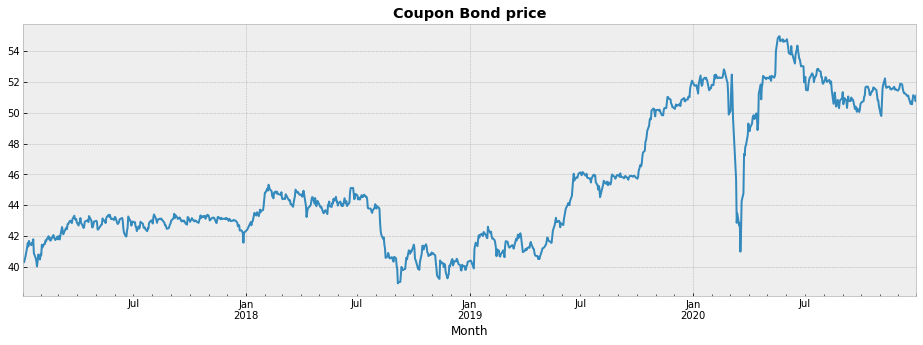

In [130]:
bond_prices.plot(figsize=(16, 5), legend=False)
plt.title("Coupon Bond price", weight="bold")

plt.show()

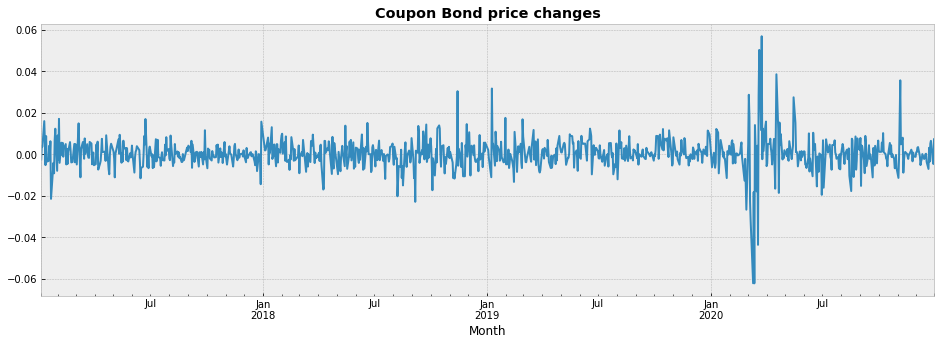

In [131]:
bond_price_changes.plot(figsize=(16, 5), legend=False)
plt.title("Coupon Bond price changes", weight="bold")

plt.show()

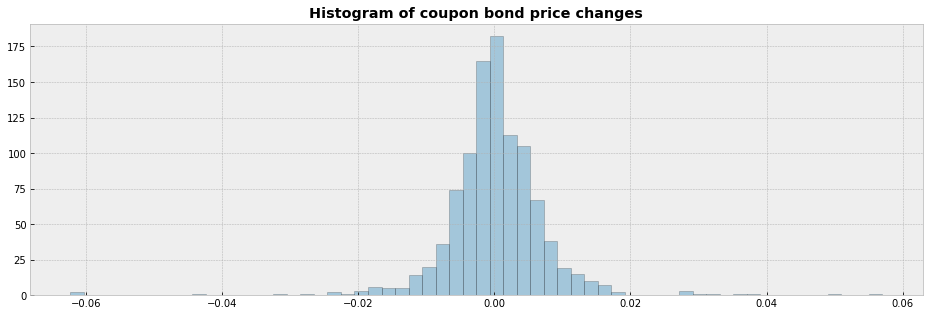

In [132]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(bond_price_changes, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of coupon bond price changes", weight="bold")

plt.show()

In [133]:
rates_changes = rates.diff().dropna()

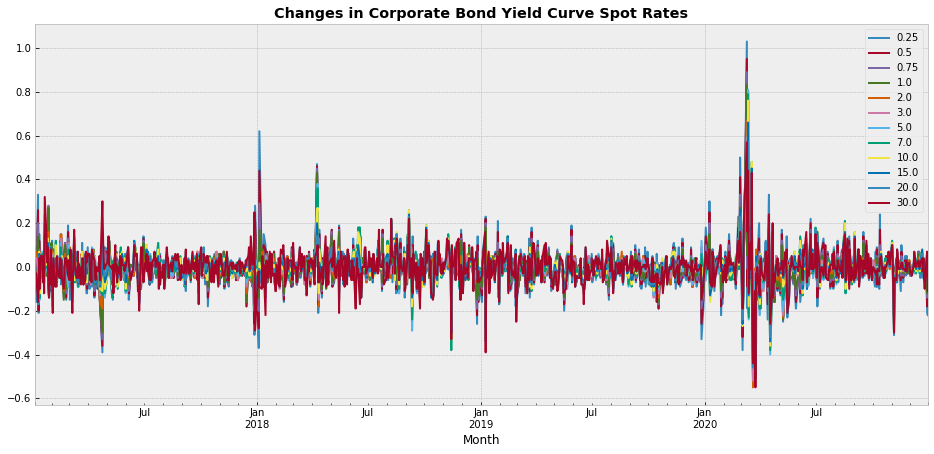

In [134]:
rates_changes.loc[:, [0.25,	0.50,	0.75,	1.00,	2.00,	3.00,	5.00,	7.00,	10.00,	15.00,	20.00,	30.00]].plot(figsize=(16, 7))
plt.title("Changes in Corporate Bond Yield Curve Spot Rates", weight="bold")

plt.show()

In [135]:
from sklearn.decomposition import PCA

In [136]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42)

pca.fit(rates_changes) # [returns.index <= datetime(2012, 3, 26rat

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

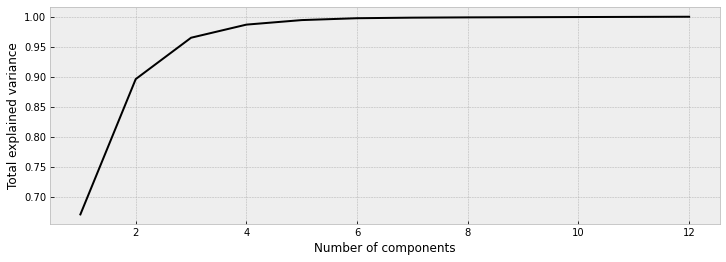

In [137]:
fig = plt.figure(figsize=(12, 4))

plt.plot(np.arange(1, rates_changes.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)

plt.xlabel('Number of components')
plt.ylabel('Total explained variance')

plt.show()

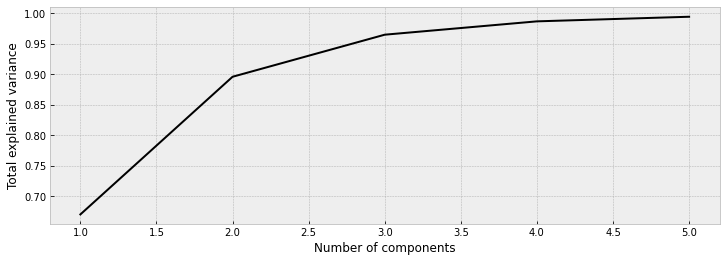

In [138]:
fig = plt.figure(figsize=(12, 4))

plt.plot(np.arange(1, 5+1), np.cumsum(pca.explained_variance_ratio_[:5]), color='k', lw=2)

plt.xlabel('Number of components')
plt.ylabel('Total explained variance')

plt.show()

In [139]:
np.cumsum(pca.explained_variance_ratio_[:4])

array([0.67054111, 0.89608513, 0.96501878, 0.98687303])

In [140]:
pca_3 = PCA(random_state=42, n_components=3)

pca_3.fit(rates_changes)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

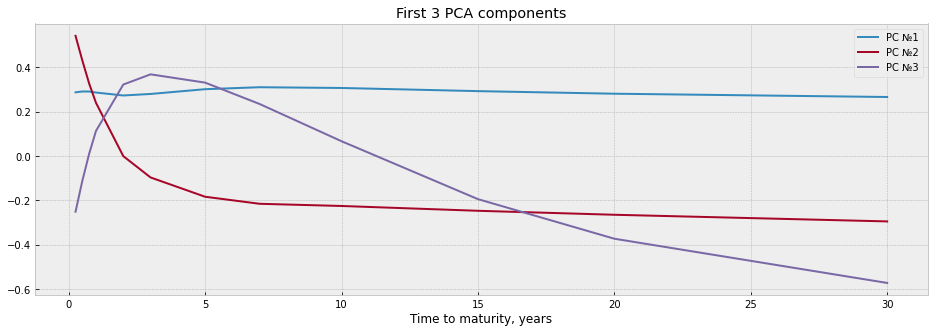

In [141]:
fig = plt.figure(figsize=(16, 5))

plt.plot(rates_changes.columns.astype(float), pca_3.components_.T) 

plt.legend(['PC №1', 'PC №2', 'PC №3'])
plt.title('First 3 PCA components')
plt.xlabel('Time to maturity, years')

plt.show()

In [142]:
principal_components = pd.DataFrame(pca_3.transform(rates_changes), 
                                    index=rates_changes.index, columns=['PC №1', 'PC №2', 'PC №3'])

principal_components.head()

,PC №1,PC №2,PC №3
Month,,,
2017-01-04,-0.025255,-0.053105,-0.074607
2017-01-05,-0.048347,0.128650,-0.018396
2017-01-06,-0.106074,-0.119020,0.113554
2017-01-09,0.051124,0.586096,0.043893
2017-01-10,-0.357266,-0.166912,0.038319


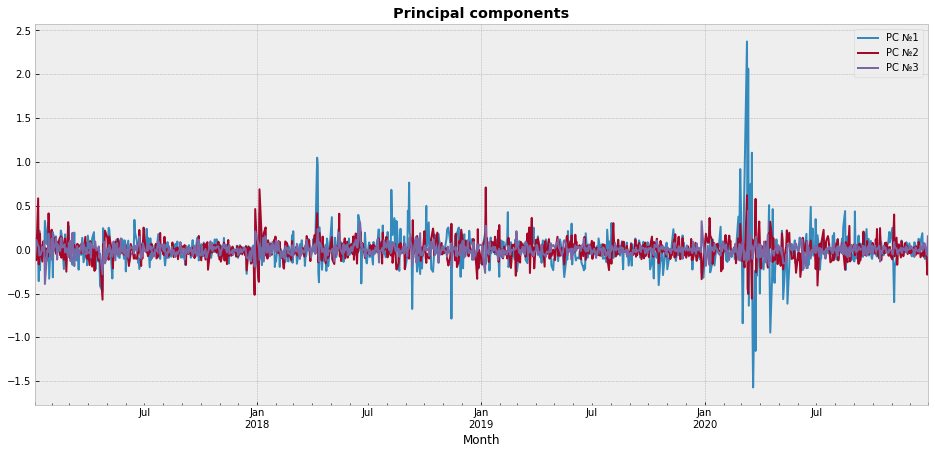

In [143]:
principal_components.plot(figsize=(16, 7))
plt.title("Principal components", weight="bold")

plt.show()

In [144]:
rates_changes_reconstructed = pca_3.inverse_transform(principal_components.values)
rates_changes_reconstructed = pd.DataFrame(rates_changes_reconstructed,
                                           columns=rates_changes.columns, index=rates_changes.index)

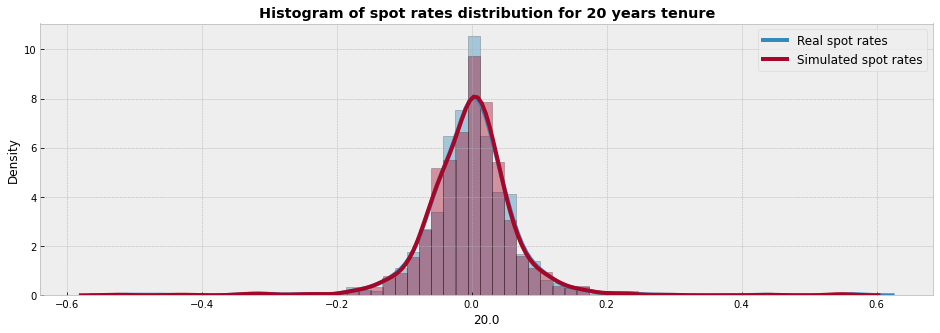

In [145]:
rate_for_hist = 20.0

fig = plt.figure(figsize=(16, 5))

sns.distplot(rates_changes.loc[:, rate_for_hist], hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(rates_changes_reconstructed.loc[:, rate_for_hist], hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real spot rates',
            'Simulated spot rates'], fontsize=12)

plt.title("Histogram of spot rates distribution for {} years tenure".format(int(float(rate_for_hist))), weight="bold")

plt.show()

In [146]:
rates_reconstruction_error = rates_changes - rates_changes_reconstructed

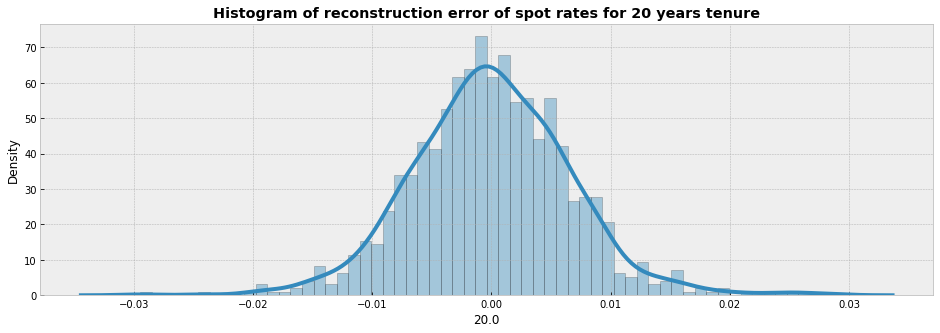

In [147]:
rate_for_hist = 20.0

fig = plt.figure(figsize=(16, 5))

sns.distplot(rates_reconstruction_error.loc[:, rate_for_hist], hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of reconstruction error of spot rates for {} years tenure".format(int(float(rate_for_hist))), weight="bold")

plt.show()

In [148]:
principal_components.corr()

,PC №1,PC №2,PC №3
PC №1,1.000000e+00,6.301726e-16,-4.009254e-17
PC №2,6.301726e-16,1.000000e+00,-3.443491e-16
PC №3,-4.009254e-17,-3.443491e-16,1.000000e+00


<Figure size 504x504 with 0 Axes>

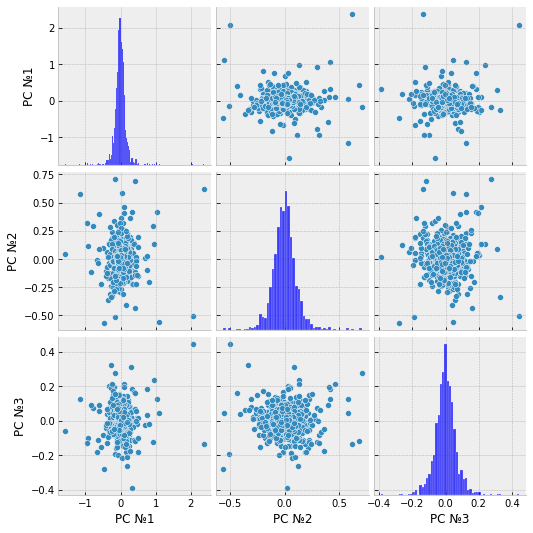

In [149]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(principal_components)

plt.show()

In [150]:
import scipy.stats as ss

n_samples = 10 ** 4

principal_components_simulations = {}

for col in principal_components.columns:
    t_df, t_mean, t_sigma = ss.t.fit(principal_components[col])
    principal_components_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
    
principal_components_simulations = pd.DataFrame(principal_components_simulations, columns=principal_components.columns)

rates_changes_simulations = pca_3.inverse_transform(principal_components_simulations.values)

rates_changes_simulations = pd.DataFrame(rates_changes_simulations, columns=rates.columns)

rates_changes_simulations

,0.25,0.50,0.75,1.00,2.00,3.00,5.00,7.00,10.00,15.00,20.00,30.00
0,0.028001,0.027214,0.026073,0.024900,0.019713,0.017471,0.014393,0.011276,0.006484,-0.002037,-0.008186,-0.015662
1,-0.071337,-0.068814,-0.065621,-0.062531,-0.049938,-0.044143,-0.036322,-0.029206,-0.019120,-0.002171,0.009813,0.024217
2,0.067646,0.065580,0.062736,0.059904,0.047486,0.041805,0.033834,0.026148,0.014822,-0.004777,-0.018792,-0.035731
3,-0.059024,-0.056884,-0.054214,-0.051619,-0.041396,-0.036851,-0.030954,-0.025610,-0.017980,-0.005125,0.003967,0.014908
4,0.068354,0.066530,0.063959,0.061159,0.050675,0.047215,0.043864,0.039983,0.033041,0.020098,0.010655,-0.000934
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.052553,-0.032605,-0.014575,-0.000180,0.039269,0.056885,0.074962,0.081453,0.082033,0.082334,0.082681,0.084374
9996,0.059000,0.037781,0.018557,0.002890,-0.038253,-0.054677,-0.068614,-0.071397,-0.067770,-0.062553,-0.059372,-0.057255
9997,-0.017009,-0.011099,-0.005657,-0.001586,0.012414,0.020784,0.032979,0.040676,0.047593,0.057746,0.064695,0.073130
9998,-0.019540,-0.015060,-0.011058,-0.007520,-0.000812,-0.000066,-0.003183,-0.007772,-0.014701,-0.025509,-0.032947,-0.041389


In [151]:
principal_components.mean()

PC №1   -3.099326e-18
PC №2   -5.534512e-19
PC №3   -4.981060e-19
dtype: float64

In [152]:
principal_components_simulations.mean()

PC №1   -0.006686
PC №2   -0.002849
PC №3   -0.000744
dtype: float64

In [153]:
principal_components.corr()

,PC №1,PC №2,PC №3
PC №1,1.000000e+00,6.301726e-16,-4.009254e-17
PC №2,6.301726e-16,1.000000e+00,-3.443491e-16
PC №3,-4.009254e-17,-3.443491e-16,1.000000e+00


In [154]:
principal_components_simulations.corr()

,PC №1,PC №2,PC №3
PC №1,1.000000,-0.001119,-0.001878
PC №2,-0.001119,1.000000,0.021402
PC №3,-0.001878,0.021402,1.000000


<Figure size 504x504 with 0 Axes>

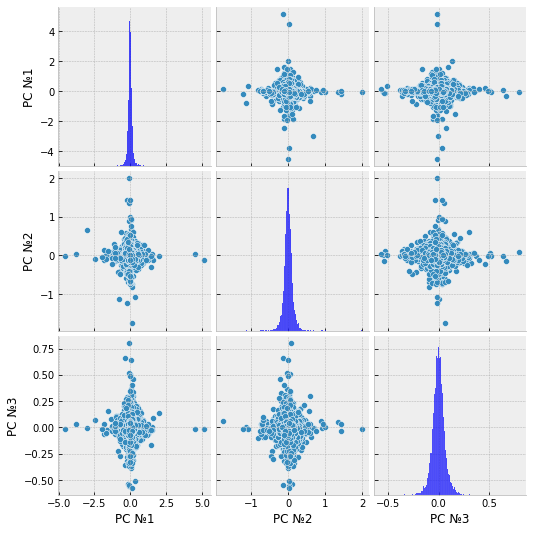

In [155]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(pd.DataFrame(principal_components_simulations))

plt.show()

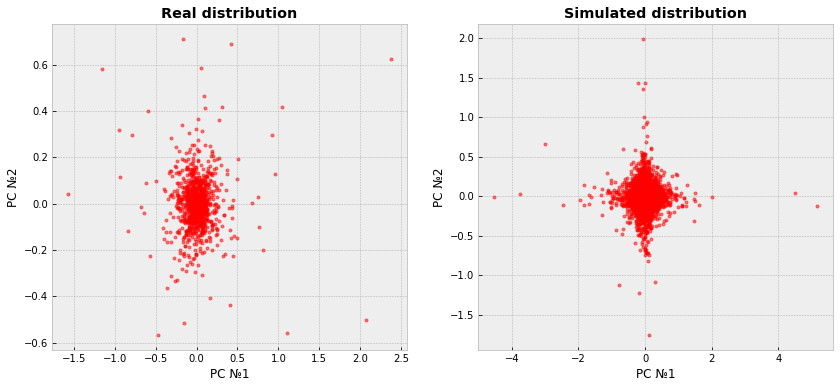

In [156]:
x = 'PC №1'
y = 'PC №2'

fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

plt1.plot(principal_components.loc[:, x], principal_components.loc[:, y], "r.", alpha=0.5)

plt1.set_xlabel(x)
plt1.set_ylabel(y)
plt1.set_title("Real distribution", weight="bold")


plt2.plot(principal_components_simulations.loc[:, x], principal_components_simulations.loc[:, y], "r.", alpha=0.5)

plt2.set_xlabel(x)
plt2.set_ylabel(y)
plt2.set_title("Simulated distribution", weight="bold")

plt.show()

In [157]:
rates.iloc[-1]

0.25     3.68
0.50     3.87
0.75     4.05
1.00     4.18
2.00     4.57
3.00     4.91
5.00     5.47
7.00     5.87
10.00    6.27
15.00    6.62
20.00    6.80
30.00    6.96
Name: 2020-12-30, dtype: float64

In [158]:
rates_changes_simulations

,0.25,0.50,0.75,1.00,2.00,3.00,5.00,7.00,10.00,15.00,20.00,30.00
0,0.028001,0.027214,0.026073,0.024900,0.019713,0.017471,0.014393,0.011276,0.006484,-0.002037,-0.008186,-0.015662
1,-0.071337,-0.068814,-0.065621,-0.062531,-0.049938,-0.044143,-0.036322,-0.029206,-0.019120,-0.002171,0.009813,0.024217
2,0.067646,0.065580,0.062736,0.059904,0.047486,0.041805,0.033834,0.026148,0.014822,-0.004777,-0.018792,-0.035731
3,-0.059024,-0.056884,-0.054214,-0.051619,-0.041396,-0.036851,-0.030954,-0.025610,-0.017980,-0.005125,0.003967,0.014908
4,0.068354,0.066530,0.063959,0.061159,0.050675,0.047215,0.043864,0.039983,0.033041,0.020098,0.010655,-0.000934
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.052553,-0.032605,-0.014575,-0.000180,0.039269,0.056885,0.074962,0.081453,0.082033,0.082334,0.082681,0.084374
9996,0.059000,0.037781,0.018557,0.002890,-0.038253,-0.054677,-0.068614,-0.071397,-0.067770,-0.062553,-0.059372,-0.057255
9997,-0.017009,-0.011099,-0.005657,-0.001586,0.012414,0.020784,0.032979,0.040676,0.047593,0.057746,0.064695,0.073130
9998,-0.019540,-0.015060,-0.011058,-0.007520,-0.000812,-0.000066,-0.003183,-0.007772,-0.014701,-0.025509,-0.032947,-0.041389


In [159]:
bond_price_simulations = (rates.iloc[-1] + rates_changes_simulations).apply(bond_value, axis=1)

bond_price_changes_simulations = bond_price_simulations / bond_prices.iloc[-1] - 1

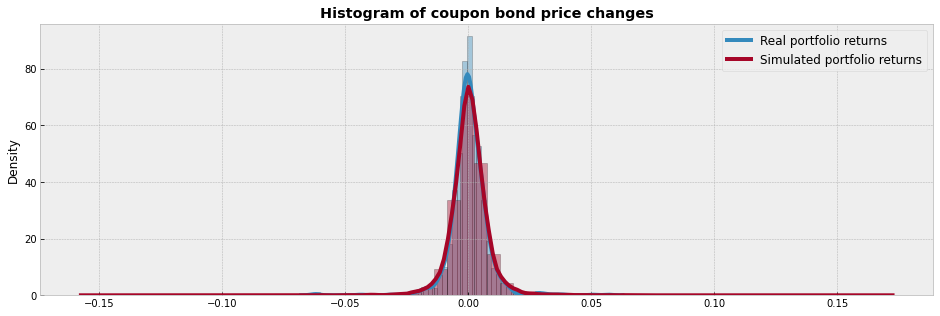

In [160]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(bond_price_changes, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(bond_price_changes_simulations, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)

plt.title("Histogram of coupon bond price changes", weight="bold")

plt.show()

In [169]:
def make_dummy_historical_simulations(returns):
    
    return returns


def make_dummy_student_simulations(returns, n_samples=10**3):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = ss.t.fit(returns[col])
        return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def pca_plus_student(returns, n_samples=10**3):
    
    pca = PCA(random_state=42, n_components=3)

    returns_rotated = pca.fit_transform(returns)
    returns_rotated = pd.DataFrame(returns_rotated)

    returns_rotated_simulations = make_dummy_student_simulations(returns_rotated, n_samples=n_samples)

    return_simulations = pca.inverse_transform(returns_rotated_simulations)
    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations


def calc_VaR_bond(r, r_diff, sampling_fun, L_history=252, level=0.05):
    VaR = np.full(r_diff.shape[0], np.nan)
    
    for i in range(L_history, r_diff.shape[0]):
        history = r_diff[i - L_history: i]
        current_rates = r.values[i]
        current_bond_value = bond_value(r.values[i])
                
        try:
            return_simulations = sampling_fun(history)
            
            # portfolio/bond return calculated differently !!!
#             portfolio_simulated_returns = np.dot(return_simulations.values, w)

            bond_price_simulations = (current_rates + return_simulations).apply(bond_value, axis=1)
            portfolio_simulated_returns = bond_price_simulations / current_bond_value - 1

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
    
    return pd.Series(data=VaR, index=r_diff.index, name=sampling_fun.__name__)

In [162]:
len(rates_changes)

1003

In [170]:
VaR_t = calc_VaR_bond(rates, rates_changes, pca_plus_student)
VaR_HS = calc_VaR_bond(rates, rates_changes, make_dummy_historical_simulations)

In [1]:
bond_price_changes.head()

NameError: ignored

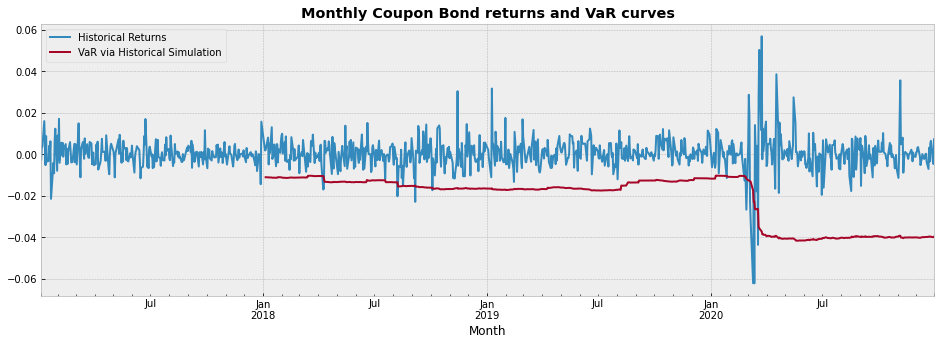

In [168]:
fig = plt.figure(figsize=(16, 5))

bond_price_changes.plot()
VaR_HS.plot()

plt.title("Monthly Coupon Bond returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation'
           ])

plt.show()

In [166]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))


def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [167]:
backtest_results(bond_price_changes, VaR_HS, alpha=0.01)

Target share of violations: 1.00%
Observed share of violations: 1.86%

Test for coverage isn't passed

Test for independence isn't passed
